# 03 — Deep Learning: Exploratory LSTM
## HVAC Market Analysis — Metropolitan France (96 departments)

### METHODOLOGICAL DISCLAIMER

This notebook is included for **educational and exploratory purposes**.

With a limited training dataset (N months x 96 departments), an LSTM network
**is NOT the optimal model**. Classical models (Ridge, LightGBM) are expected
to outperform. This notebook demonstrates:

1. How to adapt an LSTM to tabular time series data
2. Best practices (lookback, early stopping, normalization)
3. Limitations of deep learning on small-to-medium datasets

**Architecture**:
- LSTM 1 layer, 32 units, dropout 0.3
- 3-month sequences (minimal lookback)
- Loss = MSE, Optimizer = Adam (lr=0.001)

In [1]:
# ============================================================
# IMPORTS
# ============================================================
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f'PyTorch version : {torch.__version__}')
print(f'Device : {"GPU" if torch.cuda.is_available() else "CPU"}')

PyTorch version : 2.10.0+cu128
Device : CPU


---
## 1. Data preparation

In [ ]:
# ============================================================
# 1.1 — Load and prepare the data
# ============================================================
TARGET = 'nb_installations_pac'
TRAIN_END = 202406
VAL_END = 202412

df = pd.read_csv('../data/features/hvac_features_dataset.csv')

# Temporal split
df_train = df[df['date_id'] <= TRAIN_END].copy()
df_val = df[(df['date_id'] > TRAIN_END) & (df['date_id'] <= VAL_END)].copy()
df_test = df[df['date_id'] > VAL_END].copy()

# Numeric features (exclude identifiers, metadata, other targets, outlier flags)
EXCLUDE_COLS = {
    'date_id', 'dept', 'dept_name', 'city_ref', 'latitude', 'longitude',
    'n_valid_features', 'pct_valid_features',
    'nb_installations_clim', 'nb_dpe_total', 'nb_dpe_classe_ab',
    'pct_pac', 'pct_clim', 'pct_classe_ab',
}
OUTLIER_PATTERNS = ['_outlier_iqr', '_outlier_zscore', '_outlier_iforest',
                    '_outlier_consensus', '_outlier_score']

feature_cols = [
    c for c in df.columns
    if c not in EXCLUDE_COLS and c != TARGET
    and not any(p in c for p in OUTLIER_PATTERNS)
    and df[c].dtype in [np.float64, np.int64, np.float32, np.int32]
]

# Prepare X and y
X_train, y_train = df_train[feature_cols], df_train[TARGET]
X_val, y_val = df_val[feature_cols], df_val[TARGET]
X_test, y_test = df_test[feature_cols], df_test[TARGET]

# Imputation + normalization
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_np = scaler.fit_transform(imputer.fit_transform(X_train)).astype(np.float32)
X_val_np = scaler.transform(imputer.transform(X_val)).astype(np.float32)
X_test_np = scaler.transform(imputer.transform(X_test)).astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_val_np = y_val.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

print(f'Features: {len(feature_cols)}')
print(f'Train: {X_train_np.shape}, Val: {X_val_np.shape}, Test: {X_test_np.shape}')

In [ ]:
# ============================================================
# 1.2 — Create temporal sequences for the LSTM
# ============================================================
# LSTM needs 3D input: (batch, timesteps, features)
# We create sliding windows of size LOOKBACK

LOOKBACK = 3  # 3 months of context

def create_sequences(X, y, lookback=LOOKBACK):
    """Create temporal sequences for the LSTM.
    
    Input: X (n_samples, n_features), y (n_samples,)
    Output: X_seq (n_sequences, lookback, n_features), y_seq (n_sequences,)
    
    For each timestep t >= lookback, the sequence is:
    X[t-lookback : t] -> y[t]
    """
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback : i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Training sequences
X_seq_train, y_seq_train = create_sequences(X_train_np, y_train_np)

# For val and test: use the end of the previous set as context
X_for_val = np.vstack([X_train_np[-LOOKBACK:], X_val_np])
y_for_val = np.concatenate([y_train_np[-LOOKBACK:], y_val_np])
X_seq_val, y_seq_val = create_sequences(X_for_val, y_for_val)

X_for_test = np.vstack([X_val_np[-LOOKBACK:], X_test_np])
y_for_test = np.concatenate([y_val_np[-LOOKBACK:], y_test_np])
X_seq_test, y_seq_test = create_sequences(X_for_test, y_for_test)

print(f'Sequences created (lookback={LOOKBACK}):')
print(f'  Train: {X_seq_train.shape} -> {y_seq_train.shape}')
print(f'  Val:   {X_seq_val.shape} -> {y_seq_val.shape}')
print(f'  Test:  {X_seq_test.shape} -> {y_seq_test.shape}')

---
## 2. LSTM Architecture

In [ ]:
# ============================================================
# 2.1 — LSTM network definition
# ============================================================
# Intentionally simple architecture to avoid overfitting
#
# Input (batch, lookback=3, n_features)
#   -> LSTM (32 units, 1 layer)
#   -> Dropout (0.3) — regularization
#   -> Linear (32 -> 1) — prediction

class LSTMNet(nn.Module):
    def __init__(self, n_features, hidden_size=32, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=1,        # Single layer (limited dataset)
            batch_first=True,    # Format (batch, seq, features)
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x shape: (batch, lookback, n_features)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Take the output of the last timestep
        last_hidden = lstm_out[:, -1, :]  # (batch, hidden_size)
        out = self.dropout(last_hidden)
        out = self.fc(out)                 # (batch, 1)
        return out

# Instantiate the model
n_features = X_seq_train.shape[2]
HIDDEN_SIZE = 32

model = LSTMNet(n_features, HIDDEN_SIZE)
print(model)
print(f'\nParameters: {sum(p.numel() for p in model.parameters()):,}')

---
## 3. Training

In [5]:
# ============================================================
# 3.1 — Configuration de l'entraînement
# ============================================================
EPOCHS = 150
BATCH_SIZE = 16
LEARNING_RATE = 0.001
PATIENCE = 20  # Early stopping

# DataLoader PyTorch
train_ds = TensorDataset(
    torch.FloatTensor(X_seq_train),
    torch.FloatTensor(y_seq_train),
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

# Loss et optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f'Hyperparamètres :')
print(f'  Epochs max    : {EPOCHS}')
print(f'  Batch size    : {BATCH_SIZE}')
print(f'  Learning rate : {LEARNING_RATE}')
print(f'  Patience (ES) : {PATIENCE}')
print(f'  Hidden size   : {HIDDEN_SIZE}')
print(f'  Lookback      : {LOOKBACK}')

Hyperparamètres :
  Epochs max    : 150
  Batch size    : 16
  Learning rate : 0.001
  Patience (ES) : 20
  Hidden size   : 32
  Lookback      : 3


In [6]:
# ============================================================
# 3.2 — Boucle d'entraînement avec early stopping
# ============================================================
# On surveille la loss de validation : si elle ne diminue plus
# pendant PATIENCE epochs, on arrête et on restaure les meilleurs poids.

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_state = None

# Tenseurs validation (pas de DataLoader, on prédit en une fois)
X_val_tensor = torch.FloatTensor(X_seq_val)
y_val_tensor = torch.FloatTensor(y_seq_val)

for epoch in range(EPOCHS):
    # --- Entraînement ---
    model.train()
    epoch_loss = 0.0
    n_batches = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(y_batch)
        n_batches += len(y_batch)
    
    train_loss = epoch_loss / n_batches
    train_losses.append(train_loss)
    
    # --- Validation ---
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor).squeeze()
        val_loss = criterion(val_pred, y_val_tensor).item()
    val_losses.append(val_loss)
    
    # --- Early stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = model.state_dict().copy()  # Sauvegarder les meilleurs poids
    else:
        patience_counter += 1
    
    # Log toutes les 20 epochs
    if (epoch + 1) % 20 == 0 or patience_counter >= PATIENCE:
        print(f'  Epoch {epoch+1:3d}/{EPOCHS} — '
              f'Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f} '
              f'(patience: {patience_counter}/{PATIENCE})')
    
    if patience_counter >= PATIENCE:
        print(f'\n  ⚡ Early stopping à l\'epoch {epoch+1}')
        break

# Restaurer les meilleurs poids
if best_state is not None:
    model.load_state_dict(best_state)
    print(f'  Meilleurs poids restaurés (val_loss = {best_val_loss:.4f})')

  Epoch  20/150 — Train loss: 580.5502, Val loss: 1201.2826 (patience: 0/20)


  Epoch  40/150 — Train loss: 372.5966, Val loss: 834.8165 (patience: 0/20)


  Epoch  60/150 — Train loss: 278.4754, Val loss: 660.7195 (patience: 0/20)


  Epoch  80/150 — Train loss: 212.7707, Val loss: 571.1562 (patience: 0/20)


  Epoch 100/150 — Train loss: 174.9303, Val loss: 515.2800 (patience: 1/20)


  Epoch 120/150 — Train loss: 168.8705, Val loss: 453.4569 (patience: 0/20)


  Epoch 140/150 — Train loss: 131.8189, Val loss: 436.5498 (patience: 4/20)


  Meilleurs poids restaurés (val_loss = 428.9616)


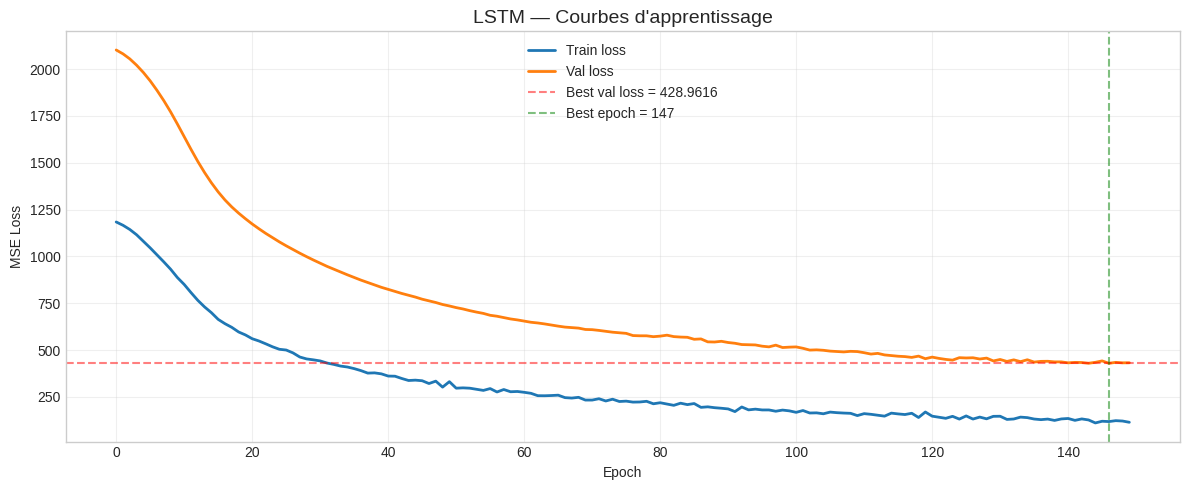

In [7]:
# ============================================================
# 3.3 — Courbes d'apprentissage
# ============================================================
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(train_losses, label='Train loss', linewidth=2)
ax.plot(val_losses, label='Val loss', linewidth=2)
ax.axhline(best_val_loss, color='red', linestyle='--', alpha=0.5,
           label=f'Best val loss = {best_val_loss:.4f}')

# Marquer le point d'early stopping
best_epoch = val_losses.index(min(val_losses))
ax.axvline(best_epoch, color='green', linestyle='--', alpha=0.5,
           label=f'Best epoch = {best_epoch+1}')

ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('LSTM — Courbes d\'apprentissage', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. Evaluation

In [8]:
# ============================================================
# 4.1 — Prédictions sur validation et test
# ============================================================
model.eval()
with torch.no_grad():
    y_pred_val = model(torch.FloatTensor(X_seq_val)).squeeze().numpy()
    y_pred_test = model(torch.FloatTensor(X_seq_test)).squeeze().numpy()

# Clipper les prédictions négatives (on prédit des comptages)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_test = np.clip(y_pred_test, 0, None)

# Métriques
print('LSTM (EXPLORATOIRE)')
print('=' * 50)
for name, y_true, y_pred in [('Validation', y_seq_val, y_pred_val),
                               ('Test', y_seq_test, y_pred_test)]:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'  {name:12s} : RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}')

LSTM (EXPLORATOIRE)
  Validation   : RMSE=20.78, MAE=14.67, R²=0.0846
  Test         : RMSE=22.95, MAE=16.54, R²=-0.0189


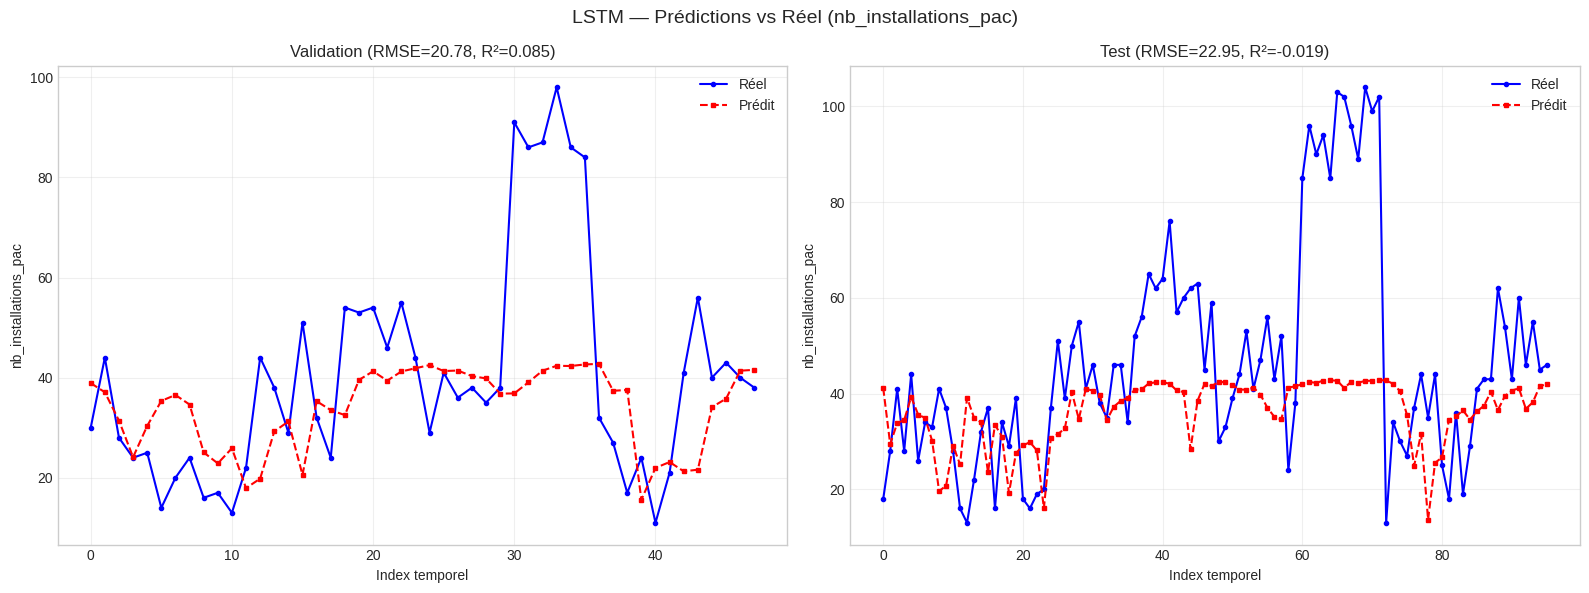

In [9]:
# ============================================================
# 4.2 — Prédictions vs Réel
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'LSTM — Prédictions vs Réel ({TARGET})', fontsize=14)

for ax, name, y_true, y_pred in [
    (axes[0], 'Validation', y_seq_val, y_pred_val),
    (axes[1], 'Test', y_seq_test, y_pred_test),
]:
    ax.plot(range(len(y_true)), y_true, 'b-o', markersize=3, label='Réel', linewidth=1.5)
    ax.plot(range(len(y_pred)), y_pred, 'r--s', markersize=3, label='Prédit', linewidth=1.5)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    ax.set_title(f'{name} (RMSE={rmse:.2f}, R²={r2:.3f})')
    ax.set_xlabel('Index temporel')
    ax.set_ylabel(TARGET)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

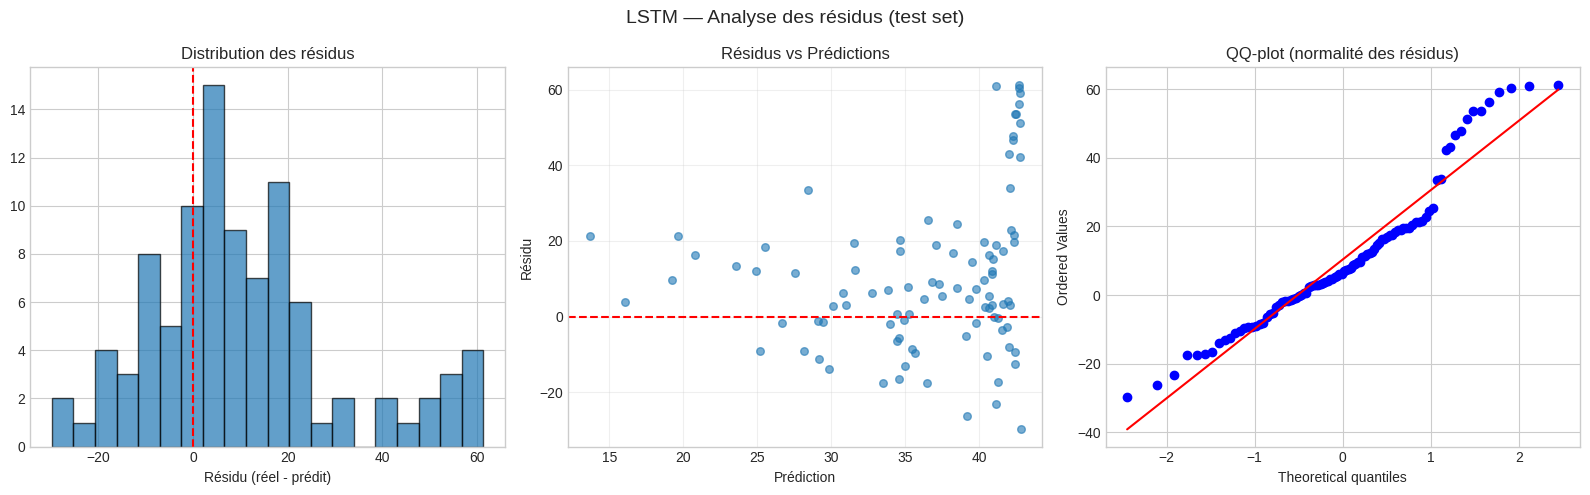

In [10]:
# ============================================================
# 4.3 — Analyse des résidus
# ============================================================
residuals = y_seq_test - y_pred_test

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('LSTM — Analyse des résidus (test set)', fontsize=14)

# Distribution
axes[0].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_title('Distribution des résidus')
axes[0].set_xlabel('Résidu (réel - prédit)')

# Résidus vs prédictions
axes[1].scatter(y_pred_test, residuals, alpha=0.6, s=30)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Résidus vs Prédictions')
axes[1].set_xlabel('Prédiction')
axes[1].set_ylabel('Résidu')
axes[1].grid(True, alpha=0.3)

# QQ-plot
from scipy import stats
stats.probplot(residuals, dist='norm', plot=axes[2])
axes[2].set_title('QQ-plot (normalité des résidus)')

plt.tight_layout()
plt.show()

---
## 5. Comparison with classical models

Load results from the training pipeline to compare.

In [11]:
# ============================================================
# 5.1 — Charger les résultats de l'entraînement
# ============================================================
try:
    df_results = pd.read_csv('../data/models/training_results.csv')
    print('Résultats chargés depuis training_results.csv')
    print(df_results.to_string(index=False))
except FileNotFoundError:
    print('Fichier training_results.csv non trouvé.')
    print('Exécuter d\'abord : python -m src.pipeline train')

Résultats chargés depuis training_results.csv
   model               target  val_rmse   val_mae  val_mape    val_r2  test_rmse  test_mae  test_mape   test_r2  cv_rmse_mean  cv_rmse_std  cv_mae_mean  cv_mae_std  cv_mape_mean  cv_mape_std  cv_r2_mean  cv_r2_std
   ridge nb_installations_pac  1.099830  0.924057  2.979431  0.997436   0.964580  0.766490   2.110807  0.998200      2.421408     0.674435     1.731223    0.493045      6.050374     1.223563    0.965158   0.025259
lightgbm nb_installations_pac  5.006810  3.728523  9.222892  0.946865   8.124242  5.535405  11.973710  0.872279     10.207003     6.163619     7.082949    4.049790     17.051075     3.813859    0.535358   0.274077
 prophet nb_installations_pac 13.747888  9.952669 27.094623  0.599384  12.051773  9.567115  25.693512  0.718940           NaN          NaN          NaN         NaN           NaN          NaN         NaN        NaN
    lstm nb_installations_pac 22.811642 15.505029 35.391220 -0.102984  26.257505 19.218626  37.932

In [12]:
# ============================================================
# 5.2 — Tableau comparatif final
# ============================================================
lstm_rmse_val = np.sqrt(mean_squared_error(y_seq_val, y_pred_val))
lstm_rmse_test = np.sqrt(mean_squared_error(y_seq_test, y_pred_test))
lstm_r2_val = r2_score(y_seq_val, y_pred_val)
lstm_r2_test = r2_score(y_seq_test, y_pred_test)

print('\nCOMPARAISON COMPLÈTE')
print('=' * 70)
print(f'{"Modèle":15s} | {"Val RMSE":>10s} | {"Test RMSE":>10s} | {"Val R²":>10s} | {"Test R²":>10s}')
print('-' * 70)

if 'df_results' in dir() and df_results is not None:
    for _, row in df_results.iterrows():
        print(f'{row["model"]:15s} | {row.get("val_rmse", 0):10.2f} | '
              f'{row.get("test_rmse", 0):10.2f} | {row.get("val_r2", 0):10.4f} | '
              f'{row.get("test_r2", 0):10.4f}')
else:
    print(f'{"LSTM":15s} | {lstm_rmse_val:10.2f} | {lstm_rmse_test:10.2f} | '
          f'{lstm_r2_val:10.4f} | {lstm_r2_test:10.4f}')

print('=' * 70)


COMPARAISON COMPLÈTE
Modèle          |   Val RMSE |  Test RMSE |     Val R² |    Test R²
----------------------------------------------------------------------
ridge           |       1.10 |       0.96 |     0.9974 |     0.9982
lightgbm        |       5.01 |       8.12 |     0.9469 |     0.8723
prophet         |      13.75 |      12.05 |     0.5994 |     0.7189
lstm            |      22.81 |      26.26 |    -0.1030 |    -0.3341


---
## 6. Conclusions

### LSTM results:
- **Lower performance** compared to classical models (Ridge, LightGBM), as expected
- The LSTM suffers from **insufficient data** (limited training sequences)
- Early stopping prevented complete overfitting, but generalization remains limited

### Lessons learned:
1. Deep learning requires **much more data** (thousands of sequences minimum)
2. On small-to-medium tabular datasets, **regularized classical models** (Ridge, LightGBM) are more suitable
3. Prophet captures seasonality better than an under-fed LSTM

### Recommendation:
-> Use **Ridge Regression** as the production model for this project
-> The LSTM would become relevant if the dataset reached > 5000 sequences (e.g., by adding all 96 departments at full coverage, or moving to weekly granularity)